In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## State variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

## Process Model & Q 

In [2]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [3]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), -skew(x), axis=1)
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
    return prior_

In [4]:
# Process Noise
Q = np.array([[.001, 0, 0], [0, .001, 0], [0, 0, .00001]])

## Measurement Model & R

In [5]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [6]:
import pandas as pd

dataframe = pd.read_excel("FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")
z = np.array(dataframe)[:, 2]

x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)

coeff, r, rank, s = polyfit2d(x, y, z)

(170, 36) (170,)


In [7]:
from sklearn.metrics import r2_score

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))

rms = np.sqrt(np.mean((z.reshape(10, 17).T - fitted_surf) ** 2))
print("RMS residual =", rms)
score = r2_score(z.reshape(10, 17).T, fitted_surf)
print("R-squared value =", score)

RMS residual = 0.23193393244515742
R-squared value = 0.9944280222772985


In [8]:
def h_contact(x):
    return np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff.reshape((6, 6)))

In [9]:
# Measurement Noise
R = np.array([[rms**2]])

## Synthesized data

In [29]:
# Start point
X_start = 10
Y_start = 125

# End point
X_end = 90
Y_end = 145

steps = 1000

xtrajectory_ = np.linspace(X_start, X_end, steps)
ytrajectory_ = np.linspace(Y_start, Y_end, steps)

# when you alter the synthesis trajectory, remember to regulate the fictitious velocity !!!!
# Fictitious data: System ctrl input 

linear_vel = np.array([(X_end-X_start)/steps, (Y_end-Y_start)/steps, 0])
angular_vel = np.array([0, 0, 0])

u = np.append(linear_vel, angular_vel, axis=0)

ztrajecotry_ = np.polynomial.polynomial.polyval2d(
    xtrajectory_, 
    ytrajectory_, 
    coeff.reshape((6, 6)),
)

# format measurements

In [30]:
# Ground Truth Trajectory
xs = np.concatenate(
    (
        xtrajectory_.reshape(xtrajectory_.shape[0], 1),
        ytrajectory_.reshape(ytrajectory_.shape[0], 1),
        np.linspace(0, 0, steps).reshape(steps, 1)
    ), 
    axis=1
)

In [31]:
from numpy.random import randn

# Manually add some measurement noise into zs
zs = [np.array([ztrajecotry_[i]]+randn()*rms) for i in range(ztrajecotry_.shape[0])]

## Implementation of filter

In [37]:
dt = 1.0
x_initial = np.array([30, 115, 0])

In [38]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=1, fx=f_contact,
          hx=h_contact, dt=dt, points=sigmas)

ukf.x = x_initial
ukf.R = R
ukf.Q = Q

In [39]:
ukf

UnscentedKalmanFilter object
x = [ 30 115   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-03 0.e+00 0.e+00]
     [0.e+00 1.e-03 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.05379335]]
S = [[0.]]
K = [[0. 0. 0.]].T
y = [0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0. 0. 0. 0. 0.]].T
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual_z = <ufunc 'subtract'>
msqrt = <function cholesky at 0x0000017056DF2E80>
hx = <function h_contact at 0x0000017058BCB2E0>
fx = <function f_co

In [40]:
uxs = []
for z in zs:
    ukf.predict(u=u)
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

[[2.89691347e+01 1.16426881e+02 1.81820824e-16]
 [2.78837385e+01 1.17946487e+02 5.82859306e-16]
 [2.69501511e+01 1.19308955e+02 7.63158467e-16]
 ...
 [8.94395788e+01 1.45236160e+02 1.69117229e-14]
 [8.94958247e+01 1.45252856e+02 1.69193764e-14]
 [8.95020840e+01 1.45263026e+02 1.74366223e-14]]


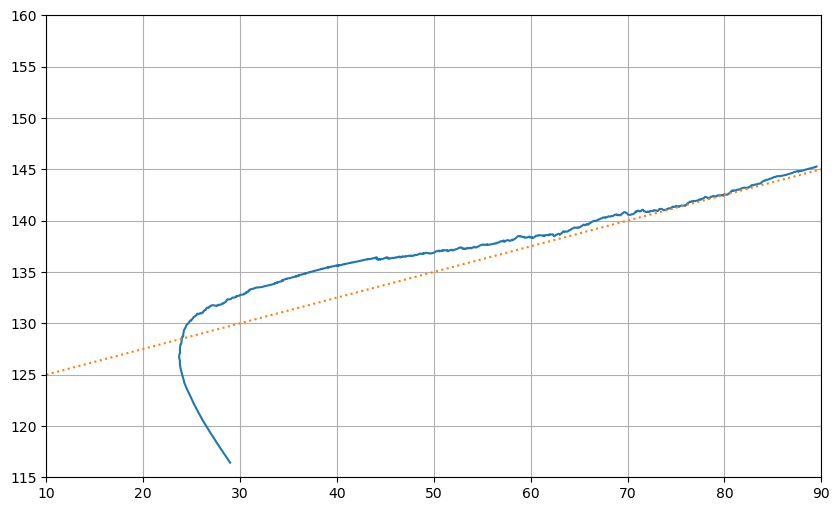

In [41]:
print(uxs)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.xlim([10, 90])
plt.plot(uxs[:, 0], uxs[:, 1], label='Estimated Trajectory')
plt.plot(xtrajectory_, ytrajectory_, label='Ground Truth', ls=':')

In [18]:
#  Evaluation 

# Euclidean Distance
dist = np.linalg.norm(uxs - xs, axis=1)
print(f'Bayesian Filter UKF tracked on ground truth with a lowest Euclidean Distance of {np.min(dist):.3f} millimeters and with a standard deviation of {np.std(dist):.3f} millimeters.')
# Converging Cost
for index, _ in enumerate(dist):
    if _ < 1:
        print(f'It costs {index+1} steps to converge to within 1mm of true location.')
        break

Bayesian Filter UKF tracked on ground truth with a lowest Euclidean Distance of 0.417 millimeters and with a standard deviation of 0.922 millimeters.
It costs 87 steps to converge to within 1mm of true location.
